In [28]:
!pip install seaborn

   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.6 kB 220.2 kB/s eta 0:00:02
   ---- ---------------------------------- 30.7/294.6 kB 220.2 kB/s eta 0:00:02
   ---- ---------------------------------- 30.7/294.6 kB 220.2 kB/s eta 0:00:02
   ---- ---------------------------------- 30.7/294.6 kB 220.2 kB/s eta 0:00:02
   -------- ------------------------------ 61.4/294.6 kB 218.8 kB/s eta 0:00:02
   ------------ -------------------------- 92.2/294.6 kB 262.6 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.6 kB 355.0 kB/s eta 0:00:01
   ------------------------------ ------- 235.5/294.6 kB 533.8 kB/s eta 0:00:01
   -------------------------------------- 294.6/294.6 kB 607.6 kB/s eta 0:00:00


In [1]:
# import required libraries
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Import the Datasets
This project is utilizing two different datasets, the "Daily Operations Details" of Natural Gas transmission and the "Daily Weather Data" of 15 weather stations in Saskatchewan from November 1, 2013 to October 31, 2023. The Daily Operations data obtained from TransGas website is the snapshot of the receipt, delivery and storage activity on the TransGas system. 

In [2]:
# Import the "Saskatchewan Daily Natural Gas Demand" dataset
transgas_df = pd.read_csv('../data/transgas-daily-operations.csv')
transgas_df.head()

,Date,Saskatchewan Receipts,Interconnected Receipts,Total Receipts,Saskatchewan Deliveries,Interconnected Deliveries,Exports,Total Deliveries,TransGas Storage Inventory,TransGas Storage % Full,Third Party Storage Injection,Third Party Storage Production,TransGas Storage Injection,TransGas Storage Production,Total Storage Activities,Operational Adjustments
0,2013-11-01,382,297,688,617,0,3,620,47098,0.0,0,0,0,0,0,-68
1,2013-11-02,380,307,696,630,0,3,633,47144,0.0,0,0,0,0,0,-63
2,2013-11-03,374,307,690,688,0,3,691,47190,0.0,0,0,0,0,0,1
3,2013-11-04,366,267,642,815,0,3,818,47201,0.0,0,0,0,0,0,176
4,2013-11-05,367,305,681,789,0,3,792,47133,0.0,0,0,0,0,0,111


In [3]:
transgas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            3652 non-null   object 
 1   Saskatchewan Receipts           3652 non-null   int64  
 2   Interconnected Receipts         3652 non-null   int64  
 3   Total Receipts                  3652 non-null   int64  
 4   Saskatchewan Deliveries         3652 non-null   int64  
 5   Interconnected Deliveries       3652 non-null   int64  
 6   Exports                         3652 non-null   int64  
 7   Total Deliveries                3652 non-null   int64  
 8   TransGas Storage Inventory      3652 non-null   int64  
 9   TransGas Storage % Full         3652 non-null   float64
 10  Third Party Storage Injection   3652 non-null   int64  
 11  Third Party Storage Production  3652 non-null   int64  
 12  TransGas Storage Injection      36

There are no null values in the TransGas DataFrame, which is great because we won’t have to do any null value imputation.

To forecast the daily consumption of natural gas in Saskatchewan using Time Series, we will be dropping the rest of the fields in transgas, except "Date" and "Saskatchewan Deliveries".

In [4]:
demand_df = transgas_df[['Date', 'Saskatchewan Deliveries']]
demand_df.head()

,Date,Saskatchewan Deliveries
0,2013-11-01,617
1,2013-11-02,630
2,2013-11-03,688
3,2013-11-04,815
4,2013-11-05,789


In [5]:
# Import the "Saskatchewan Daily Weather" dataset
weather_df = pd.read_csv('../data/weather-data.csv')
weather_df.head()

,DATE,ID,STATION_IDENTIFIER,STATION_NAME,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01 0:00,4015322.2013.11.1,4015322,MOOSE JAW CS,42.0,90.0,12.8,0.0,0.2,-0.4,5.2,10.8,29.0,48.0
1,2013-11-02 0:00,4015322.2013.11.2,4015322,MOOSE JAW CS,30.0,88.0,14.5,0.0,0.0,-5.8,3.5,12.8,11.0,32.0
2,2013-11-03 0:00,4015322.2013.11.3,4015322,MOOSE JAW CS,55.0,92.0,14.3,0.0,5.0,-0.7,3.7,8.1,30.0,59.0
3,2013-11-04 0:00,4015322.2013.11.4,4015322,MOOSE JAW CS,72.0,88.0,22.6,0.0,0.4,-8.4,-4.6,-0.7,29.0,69.0
4,2013-11-05 0:00,4015322.2013.11.5,4015322,MOOSE JAW CS,65.0,91.0,27.5,0.0,0.0,-15.5,-9.5,-3.4,30.0,41.0


In [6]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57754 entries, 0 to 57753
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  57726 non-null  object 
 1   ID                    57726 non-null  object 
 2   STATION_IDENTIFIER    57726 non-null  object 
 3   STATION_NAME          57726 non-null  object 
 4   LOWEST_REL_HUMIDITY   29393 non-null  float64
 5   HIGHEST_REL_HUMIDITY  29415 non-null  float64
 6   HEATING_DEGREE_DAYS   57023 non-null  float64
 7   COOLING_DEGREE_DAYS   57023 non-null  float64
 8   TOTAL_PRECIPITATION   56381 non-null  float64
 9   LOWEST_TEMPERATURE    57271 non-null  float64
 10  AVG_TEMPERATURE       57023 non-null  float64
 11  HIGHEST_TEMPERATURE   57068 non-null  float64
 12  DIRECTION_MAX_GUST    49554 non-null  float64
 13  SPEED_MAX_GUST        49516 non-null  float64
dtypes: float64(10), object(4)
memory usage: 6.2+ MB


## Step 2: Data Preprocessing
- Clean and handle missing data for both datasets
- Calculate the average Saskatchewan daily weather factors from all the stations- 
Combine natural gas demand and weather factors data
- 
Ensure the data is in time-series format.

#### 1. Clean and handle missing data for both datasets
Since the Natural Gas demand dataset is clean and no missing value, we will proceed to the preprocessing the weather dataset.

In [7]:
# Checking for "Station_Name" uniques
unique_values = weather_df['STATION_NAME'].unique()
print(unique_values)

['MOOSE JAW CS' 'REGINA RCS' 'YORKTON' 'WEYBURN' 'ASSINIBOIA AIRPORT'
 'MAPLE CREEK' 'SWIFT CURRENT' 'KINDERSLEY A' 'SCOTT CDA'
 'NORTH BATTLEFORD RCS' 'LLOYDMINSTER' 'MEADOW LAKE' 'PRINCE ALBERT A'
 'MELFORT' 'SASKATOON RCS' 'ESTEVAN' nan]


In [8]:
# Counting the numbers of "NaN" values in the Station_Name features
nan_count = weather_df['STATION_NAME'].isna().sum()
print(nan_count)

28


In [9]:
# Convert 'Date' column to datetime and remove time
weather_df['DATE'] = pd.to_datetime(weather_df['DATE']).dt.date
weather_df

,DATE,ID,STATION_IDENTIFIER,STATION_NAME,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,4015322.2013.11.1,4015322,MOOSE JAW CS,42.0,90.0,12.8,0.0,0.2,-0.4,5.2,10.8,29.0,48.0
1,2013-11-02,4015322.2013.11.2,4015322,MOOSE JAW CS,30.0,88.0,14.5,0.0,0.0,-5.8,3.5,12.8,11.0,32.0
2,2013-11-03,4015322.2013.11.3,4015322,MOOSE JAW CS,55.0,92.0,14.3,0.0,5.0,-0.7,3.7,8.1,30.0,59.0
3,2013-11-04,4015322.2013.11.4,4015322,MOOSE JAW CS,72.0,88.0,22.6,0.0,0.4,-8.4,-4.6,-0.7,29.0,69.0
4,2013-11-05,4015322.2013.11.5,4015322,MOOSE JAW CS,65.0,91.0,27.5,0.0,0.0,-15.5,-9.5,-3.4,30.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Drop rows with NaN in 'Date' column
weather_df = weather_df.dropna(subset=['DATE'])
weather_df

,DATE,ID,STATION_IDENTIFIER,STATION_NAME,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01 0:00,4015322.2013.11.1,4015322,MOOSE JAW CS,42.0,90.0,12.8,0.0,0.2,-0.4,5.2,10.8,29.0,48.0
1,2013-11-02 0:00,4015322.2013.11.2,4015322,MOOSE JAW CS,30.0,88.0,14.5,0.0,0.0,-5.8,3.5,12.8,11.0,32.0
2,2013-11-03 0:00,4015322.2013.11.3,4015322,MOOSE JAW CS,55.0,92.0,14.3,0.0,5.0,-0.7,3.7,8.1,30.0,59.0
3,2013-11-04 0:00,4015322.2013.11.4,4015322,MOOSE JAW CS,72.0,88.0,22.6,0.0,0.4,-8.4,-4.6,-0.7,29.0,69.0
4,2013-11-05 0:00,4015322.2013.11.5,4015322,MOOSE JAW CS,65.0,91.0,27.5,0.0,0.0,-15.5,-9.5,-3.4,30.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57721,2023-10-27 0:00,4012410.2023.10.27,4012410,ESTEVAN,73.0,88.0,26.5,0.0,0.7,-12.6,-8.5,-4.3,30.0,33.0
57722,2023-10-28 0:00,4012410.2023.10.28,4012410,ESTEVAN,67.0,90.0,25.8,0.0,0.0,-11.0,-7.8,-4.5,24.0,36.0
57723,2023-10-29 0:00,4012410.2023.10.29,4012410,ESTEVAN,69.0,90.0,23.9,0.0,0.8,-9.2,-5.9,-2.7,28.0,39.0
57724,2023-10-30 0:00,4012410.2023.10.30,4012410,ESTEVAN,55.0,84.0,28.0,0.0,0.0,-16.7,-10.0,-3.4,35.0,70.0


In [10]:
# Counting the numbers of NaN values for other columns in the weather dataset
nan_counts = weather_df.isna().sum()

# Display the NaN counts for each column
print(nan_counts)

DATE                        0
ID                          0
STATION_IDENTIFIER          0
STATION_NAME                0
LOWEST_REL_HUMIDITY     28333
HIGHEST_REL_HUMIDITY    28311
HEATING_DEGREE_DAYS       703
COOLING_DEGREE_DAYS       703
TOTAL_PRECIPITATION      1345
LOWEST_TEMPERATURE        455
AVG_TEMPERATURE           703
HIGHEST_TEMPERATURE       658
DIRECTION_MAX_GUST       8172
SPEED_MAX_GUST           8210
dtype: int64


Typically, the optimal approach to handle missing data is to eliminate the rows with these missing values. However, another method to consider is imputation, a technique that replaces missing data with artificially generated values.

Understanding that imputing annual me, r medi, oror seasonal mean or median values could significantly impact the performance of the model used to assess the influence of weather factors on natural gas demands, we’ve decided to fill all NaN values with zeros. This decision is based on the assumption that zero would have a lesser impact on the model’s performance.

In [11]:
# Replace all NaN values with 0
weather_df = weather_df.fillna(0)
weather_df

,DATE,ID,STATION_IDENTIFIER,STATION_NAME,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01 0:00,4015322.2013.11.1,4015322,MOOSE JAW CS,42.0,90.0,12.8,0.0,0.2,-0.4,5.2,10.8,29.0,48.0
1,2013-11-02 0:00,4015322.2013.11.2,4015322,MOOSE JAW CS,30.0,88.0,14.5,0.0,0.0,-5.8,3.5,12.8,11.0,32.0
2,2013-11-03 0:00,4015322.2013.11.3,4015322,MOOSE JAW CS,55.0,92.0,14.3,0.0,5.0,-0.7,3.7,8.1,30.0,59.0
3,2013-11-04 0:00,4015322.2013.11.4,4015322,MOOSE JAW CS,72.0,88.0,22.6,0.0,0.4,-8.4,-4.6,-0.7,29.0,69.0
4,2013-11-05 0:00,4015322.2013.11.5,4015322,MOOSE JAW CS,65.0,91.0,27.5,0.0,0.0,-15.5,-9.5,-3.4,30.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57721,2023-10-27 0:00,4012410.2023.10.27,4012410,ESTEVAN,73.0,88.0,26.5,0.0,0.7,-12.6,-8.5,-4.3,30.0,33.0
57722,2023-10-28 0:00,4012410.2023.10.28,4012410,ESTEVAN,67.0,90.0,25.8,0.0,0.0,-11.0,-7.8,-4.5,24.0,36.0
57723,2023-10-29 0:00,4012410.2023.10.29,4012410,ESTEVAN,69.0,90.0,23.9,0.0,0.8,-9.2,-5.9,-2.7,28.0,39.0
57724,2023-10-30 0:00,4012410.2023.10.30,4012410,ESTEVAN,55.0,84.0,28.0,0.0,0.0,-16.7,-10.0,-3.4,35.0,70.0


In [12]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57726 entries, 0 to 57725
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  57726 non-null  object 
 1   ID                    57726 non-null  object 
 2   STATION_IDENTIFIER    57726 non-null  object 
 3   STATION_NAME          57726 non-null  object 
 4   LOWEST_REL_HUMIDITY   57726 non-null  float64
 5   HIGHEST_REL_HUMIDITY  57726 non-null  float64
 6   HEATING_DEGREE_DAYS   57726 non-null  float64
 7   COOLING_DEGREE_DAYS   57726 non-null  float64
 8   TOTAL_PRECIPITATION   57726 non-null  float64
 9   LOWEST_TEMPERATURE    57726 non-null  float64
 10  AVG_TEMPERATURE       57726 non-null  float64
 11  HIGHEST_TEMPERATURE   57726 non-null  float64
 12  DIRECTION_MAX_GUST    57726 non-null  float64
 13  SPEED_MAX_GUST        57726 non-null  float64
dtypes: float64(10), object(4)
memory usage: 6.6+ MB


In [13]:
# Save the cleaned DataFrame to a new CSV file
output_file = '../data/weather_clean.csv'
weather_df.to_csv(output_file, index=False)

print(f"Missing values fixed. Saved to {output_file}")

Missing values fixed. Saved to ../data/weather_clean.csv


#### 2. Calculate the average Saskatchewan daily weather factors from all the stations

In [15]:
# Import clean "Saskatchewan Daily Weather" dataset
weather_df_clean = pd.read_csv('../data/weather_clean.csv')

In [16]:
# Drop specified columns
columns_to_drop = ['ID', 'STATION_IDENTIFIER', 'STATION_NAME']
data = weather_df_clean.drop(columns=columns_to_drop)

# Convert 'DATE' to datetime format (if not already)
data['DATE'] = pd.to_datetime(data['DATE'])

# Group by 'DATE' and calculate the average
avg_weather_df = data.groupby('DATE').mean().reset_index()

avg_weather_df.head()

,DATE,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2011-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-07-01,0.0,0.0,4.0,0.0,0.0,9.4,14.0,18.6,0.0,0.0
2,2011-07-02,0.0,0.0,1.5,0.0,0.0,7.8,16.5,25.2,0.0,0.0
3,2011-07-03,0.0,0.0,0.0,2.8,0.8,11.3,20.8,30.3,0.0,0.0
4,2011-07-04,0.0,0.0,0.7,0.0,0.0,11.3,17.3,23.2,0.0,0.0


In [17]:
# Dropping off some rows in the avg_weather_df that are outside 2013-11-01 and 2023-10-31
# Define the date range
start_date = '2013-11-01'
end_date = '2023-10-31'

# Filter rows based on the date range
avg_sask_weather_df = avg_weather_df[(avg_weather_df['DATE'] >= start_date) & (avg_weather_df['DATE'] <= end_date)]

# Save the filtered data to a new CSV file
avg_sask_weather_df.to_csv('avg_sask_weather.csv', index=False)

print(f'Data for the date range {start_date} to {end_date} has been saved to avg_sask_weather.csv')

Data for the date range 2013-11-01 to 2023-10-31 has been saved to avg_sask_weather.csv


In [18]:
avg_sask_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3652 entries, 837 to 4488
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  3652 non-null   datetime64[ns]
 1   LOWEST_REL_HUMIDITY   3652 non-null   float64       
 2   HIGHEST_REL_HUMIDITY  3652 non-null   float64       
 3   HEATING_DEGREE_DAYS   3652 non-null   float64       
 4   COOLING_DEGREE_DAYS   3652 non-null   float64       
 5   TOTAL_PRECIPITATION   3652 non-null   float64       
 6   LOWEST_TEMPERATURE    3652 non-null   float64       
 7   AVG_TEMPERATURE       3652 non-null   float64       
 8   HIGHEST_TEMPERATURE   3652 non-null   float64       
 9   DIRECTION_MAX_GUST    3652 non-null   float64       
 10  SPEED_MAX_GUST        3652 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 342.4 KB


In [19]:
# Save the average daily Saskatchewan weather data to a new CSV file
avg_sask_weather_df.to_csv('../data/avg_sask_weather.csv', index=False)

#### 3. Combine  Saskatchewan natural gas demand data and weather factors data

In [20]:
# Convert 'Date' column to datetime in both DataFrames
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
avg_sask_weather_df['DATE'] = pd.to_datetime(avg_sask_weather_df['DATE'])

# Merge the two DataFrames on the 'Date' column
combined_df = pd.merge(demand_df, avg_sask_weather_df, left_on='Date', right_on='DATE', how='inner')

# Drop the extra 'DATE' column
combined_df = combined_df.drop(columns=['DATE'])

combined_df.head()

,Date,Saskatchewan Deliveries,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


Rename the columns of the DataFrame for consistency

In [21]:
# Rename columns
combined_df = combined_df.rename(columns={
    'Date': 'DATE',
    'Saskatchewan Deliveries': 'NG_DEMAND',
})
combined_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


In [22]:
# Save the average daily Saskatchewan weather data to a new CSV file
combined_df.to_csv('../data/combined_data.csv', index=False)

## Step 3: Eploratory Data Analysis

In [23]:
# Summary statistics excluding 'Date' column
combined_df.drop(columns=['DATE']).describe()

,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,820.887733,25.931093,44.658454,15.279781,0.324363,0.892497,-3.354105,2.824987,9.005540,16.345348,33.184262
std,230.826589,27.358156,41.626202,12.806446,0.942387,1.989150,12.446918,13.157282,14.145301,8.627396,15.960761
min,347.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-39.106250,-32.740000,-28.493333,0.000000,0.000000
25%,644.750000,0.000000,0.000000,3.219688,0.000000,0.020000,-11.727083,-6.960625,-2.084271,9.562500,21.125000
50%,787.000000,22.550000,68.000000,13.575000,0.000000,0.162500,-1.758125,4.264583,10.293750,15.562500,33.933333
75%,985.000000,50.375000,85.066667,24.878125,0.000000,0.825417,7.528333,14.439063,21.457187,23.571875,44.953125
max,1532.000000,90.875000,96.312500,50.740000,9.606667,25.100000,19.046667,27.606667,36.350000,34.200000,95.285714


These statistics provide a useful summary of the central tendency, dispersion, and shape of the distribution of the dataset. However, to get a more detailed understanding of the data, visual exploratory data analysis methods such as histograms, boxplots, and scatter plots would be beneficial.

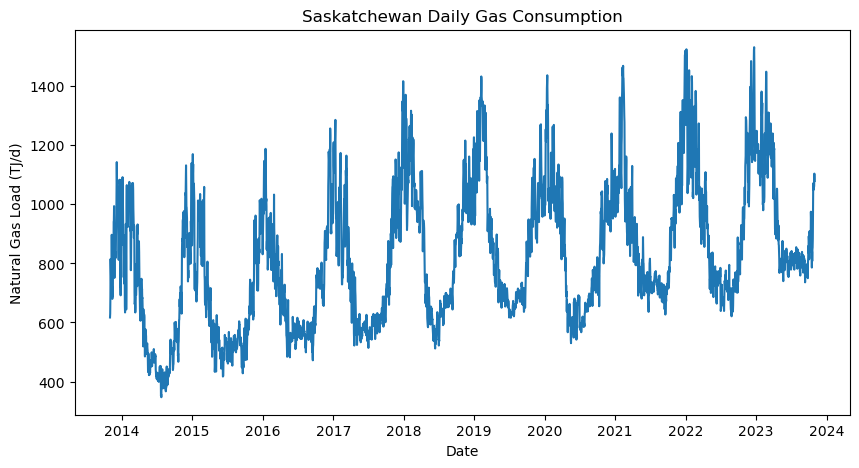

In [24]:
plt.figure(figsize=(10,5))
plt.plot(combined_df['DATE'], combined_df['NG_DEMAND'])
plt.title('Saskatchewan Daily Gas Consumption')
plt.xlabel('Date')
plt.ylabel('Natural Gas Load (TJ/d)')
plt.show()


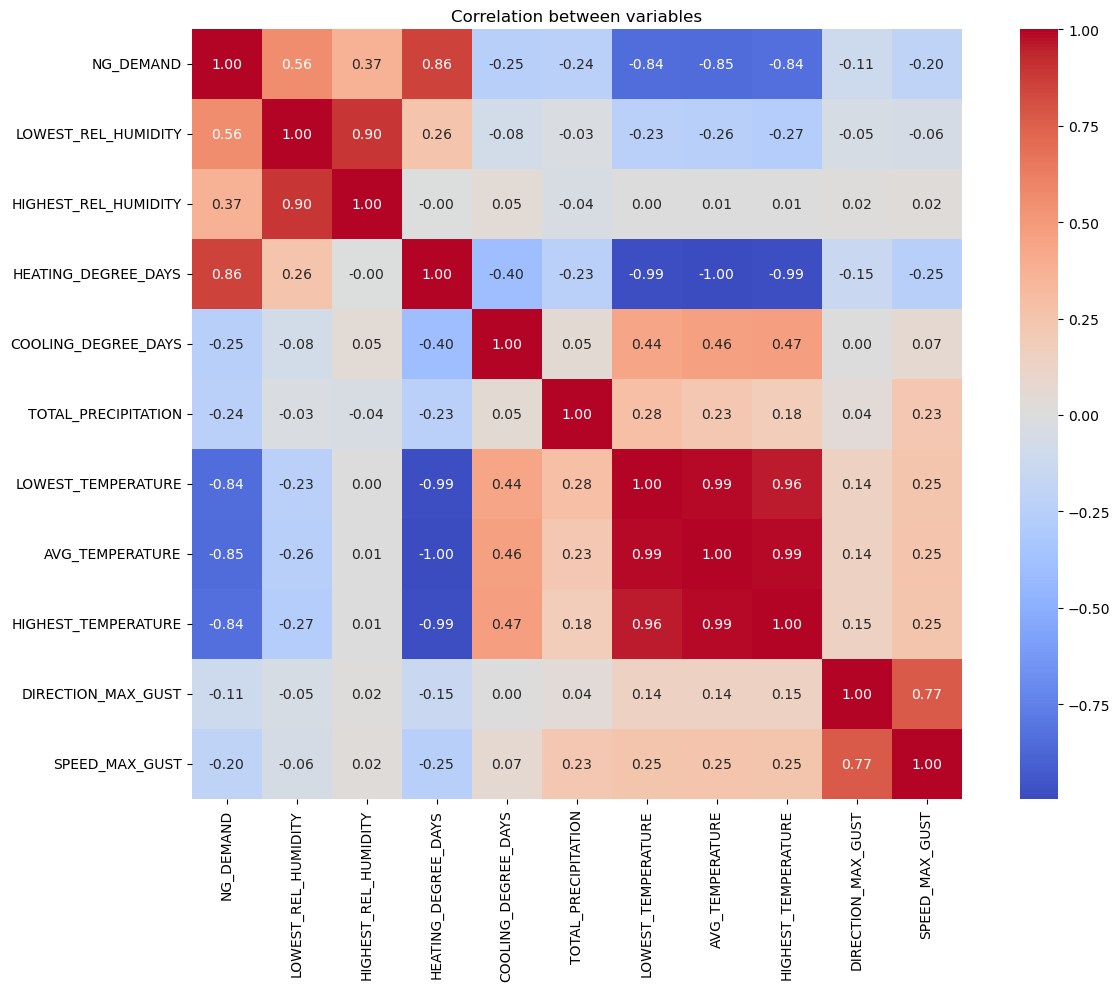

In [30]:
# Drop 'Date' column
df_without_date = combined_df.drop(columns=['DATE'])

# Correlation heatmap between feature variables
plt.figure(figsize=(15,10))
corr = df_without_date.corr()
sns.heatmap(data=corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation between variables')
plt.show()

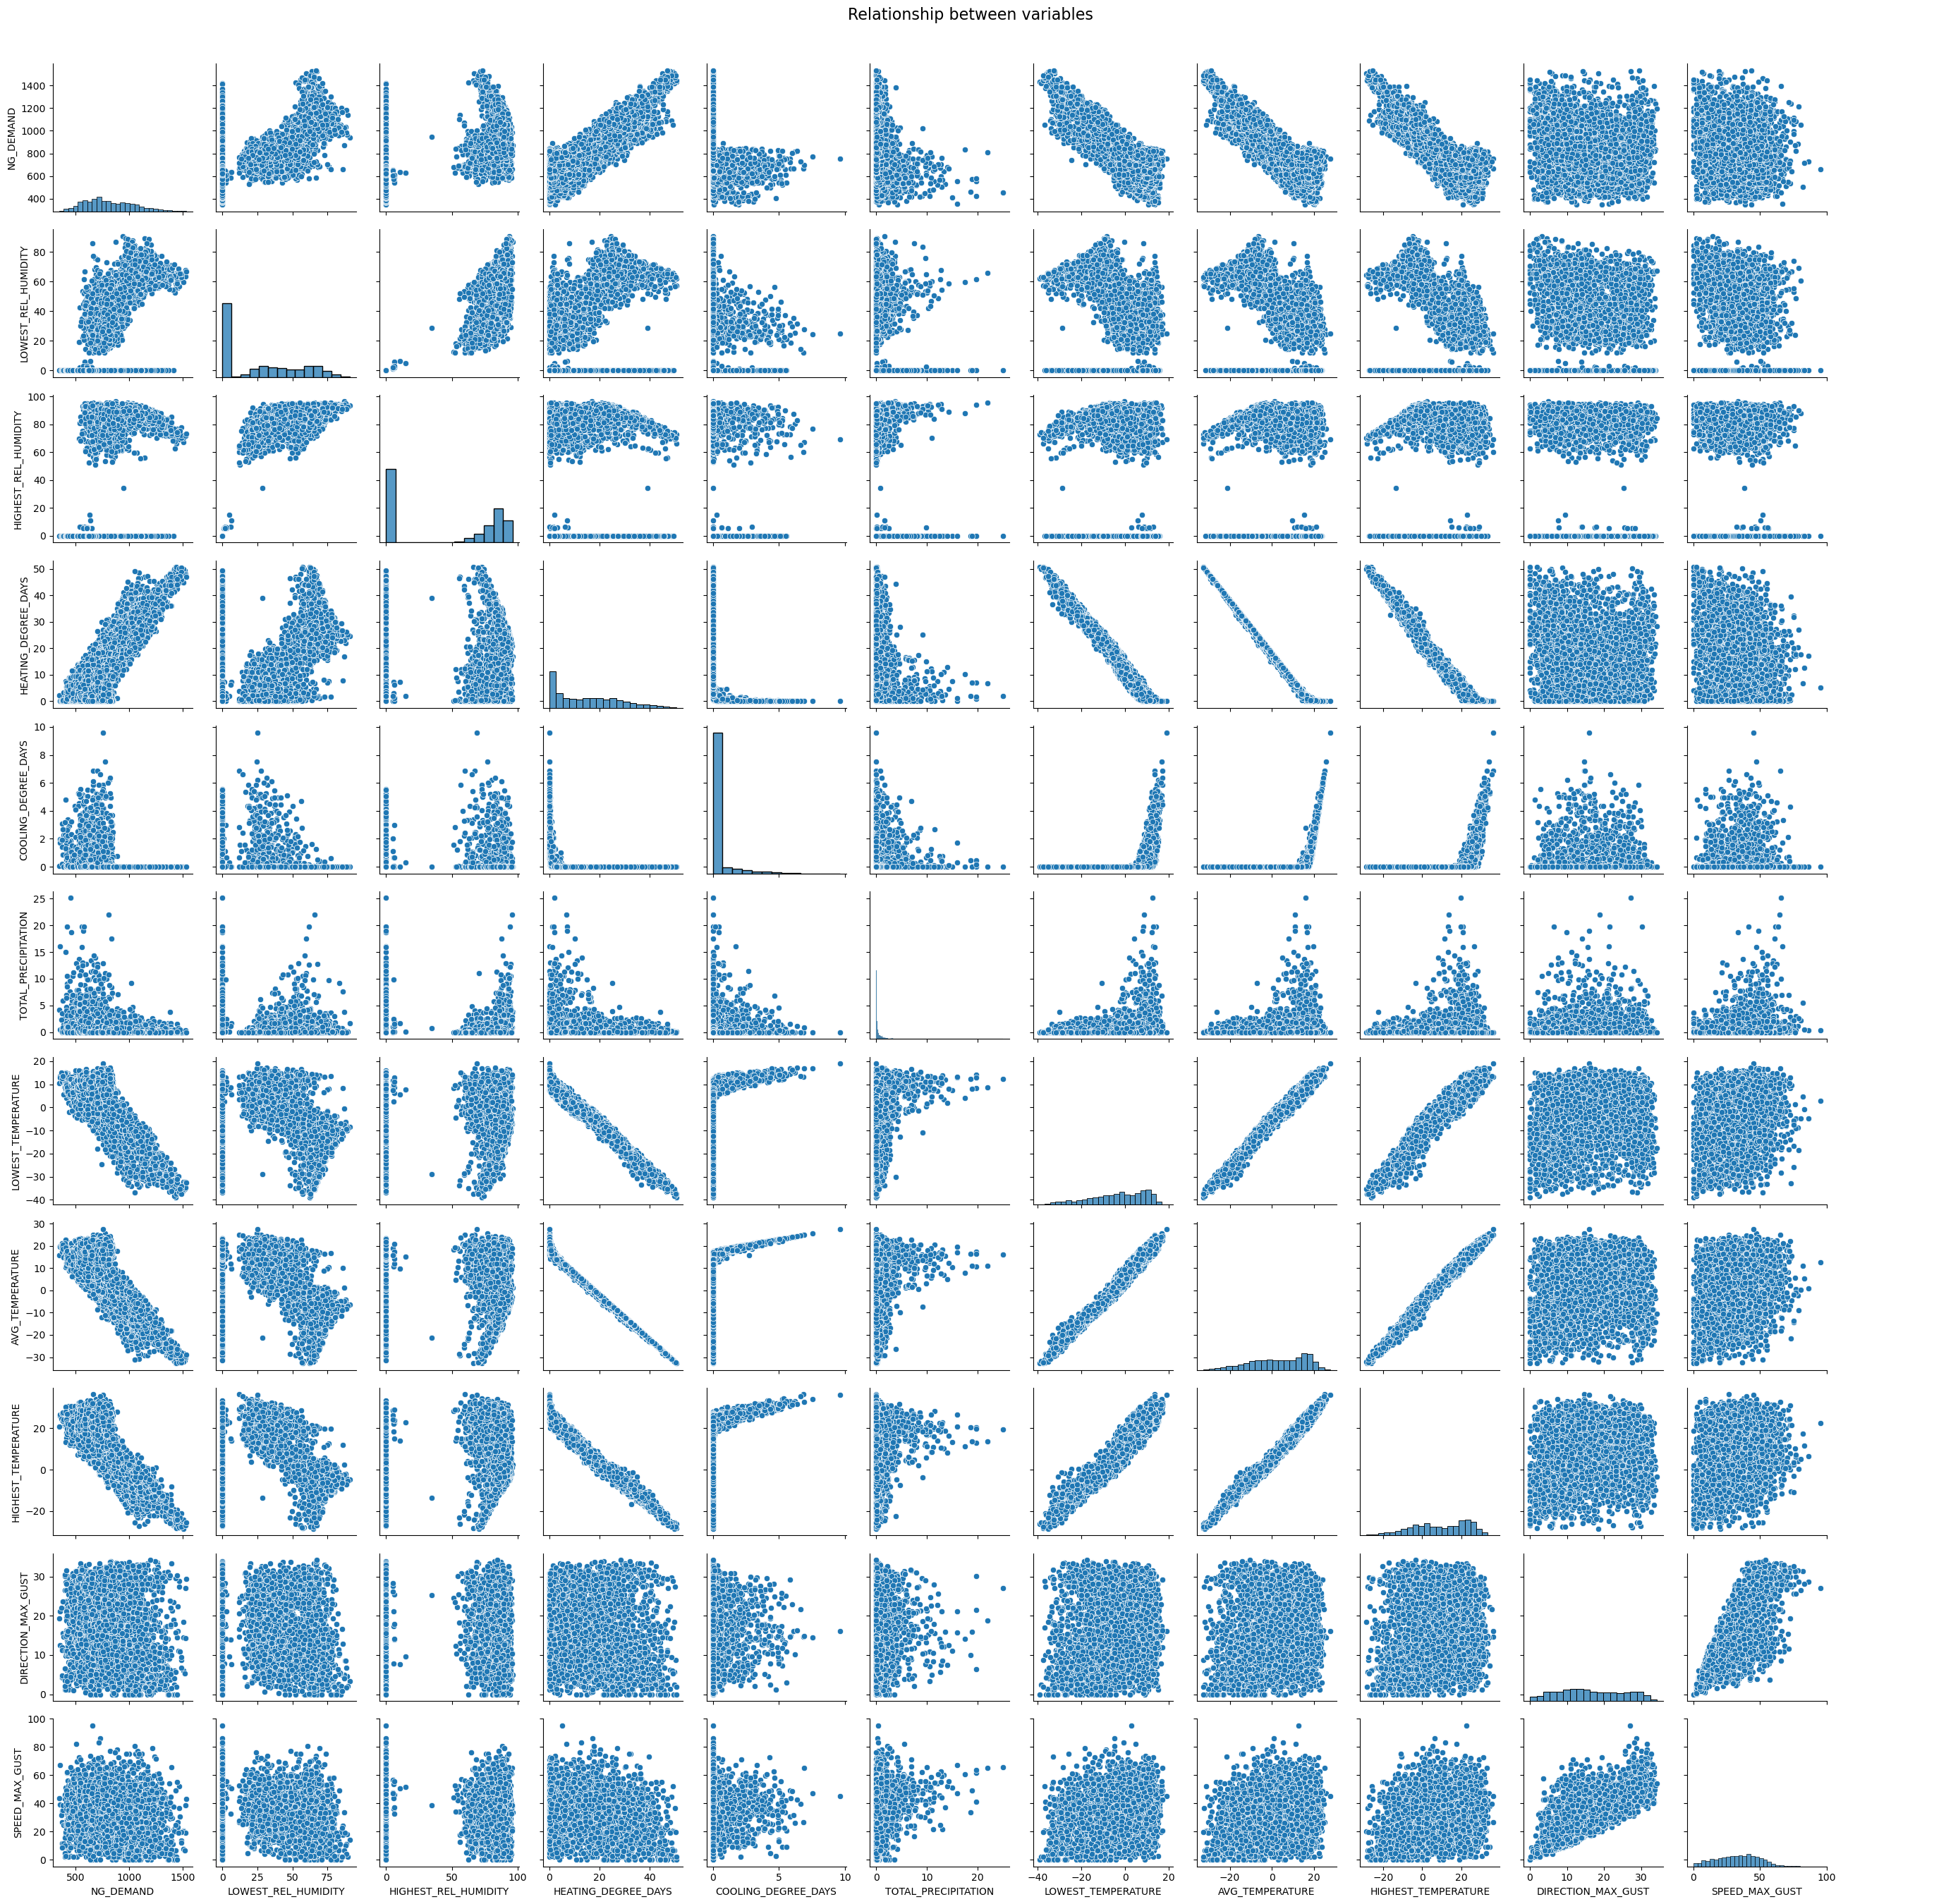

In [40]:
# Create a Pairplot to visualize relationships between variables
g = sns.pairplot(combined_df)
g.add_legend()

# Set the title at the top middle of the pair plot
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Relationship between variables", fontsize=16)

# Use plt.tight_layout() to adjust the layout
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()